In [53]:
#in this notebook, we will predict next frame (n+1) given previous two frames (n-1 and n)
#we will use horn schunck and lukas kanade algorithm to get the optical flows

In [54]:
import importlib

import utils.pixel_wise_mapping
from utils.pixel_wise_mapping import *

from utils.pixel_wise_mapping import remap_using_flow_fields
importlib.reload(utils.pixel_wise_mapping)


<module 'utils.pixel_wise_mapping' from '/home/lisa/bhartendu/DVPA/A1/utils/pixel_wise_mapping.py'>

## flowpy: -> to provide optical flow utilities
1. flow to image
2. wrap forward flow
3. warp backward flow

In [78]:
import flowpy

In [55]:
#libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import scipy.ndimage
import scipy.signal


In [56]:
from torchvision.utils import flow_to_image
import torch

#### parameters

In [76]:
N = 9
lambada = 1E-10
iterations = 100

In [58]:
first_frame_path = 'bt.000.pgm'
second_frame_path = 'bt.001.pgm'
third_frame_path = 'bt.002.pgm'

In [59]:
#load all 3 frames
first_frame = cv2.imread(first_frame_path)
second_frame = cv2.imread(second_frame_path)
third_frame = cv2.imread(third_frame_path)


#make gray scale
first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
second_frame = cv2.cvtColor(second_frame, cv2.COLOR_BGR2GRAY)
third_frame = cv2.cvtColor(third_frame, cv2.COLOR_BGR2GRAY)

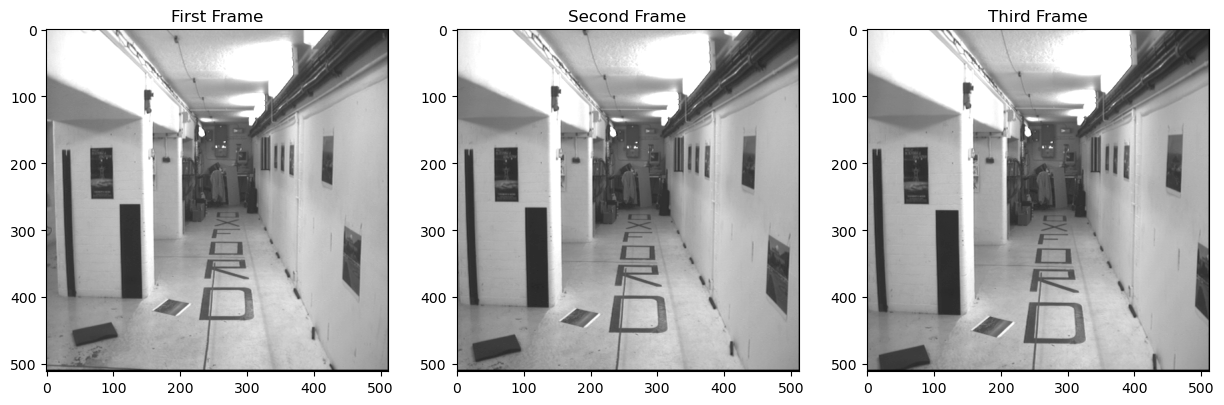

In [60]:
#show all 3 frames in a single plot, single row, 3 columns
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(first_frame, cmap='gray')
#title: first frame
ax[0].set_title('First Frame')
ax[1].imshow(second_frame, cmap='gray')
#title: second frame
ax[1].set_title('Second Frame')
ax[2].imshow(third_frame, cmap='gray')
#title: third frame
ax[2].set_title('Third Frame')

#show the plot
plt.show()




In [61]:

def compute_gradients(firstImage, secondImage):
    """
    Compute gradients in x, y and t direction between images
    :param firstImage: First image
    :param secondImage: Second image
    :return: Gradients
    """

    firstImage = firstImage / 255
    secondImage = secondImage / 255

    # Kernels for finding gradients Ix, Iy, It
    kernel_x = np.array([[-1, 1]])
    kernel_y = np.array([[-1], [1]])
    kernel_t = np.array([[1]])



    Ix = scipy.ndimage.convolve(input=firstImage, weights=kernel_x, mode="nearest")
    Iy = scipy.ndimage.convolve(input=firstImage, weights=kernel_y, mode="nearest")
    It = scipy.ndimage.convolve(input=secondImage, weights=kernel_t, mode="nearest") + scipy.ndimage.convolve(
        input=firstImage, weights=-kernel_t, mode="nearest"
    )

    I = [Ix, Iy, It]

    return I

In [62]:

def horn_schunk(firstImage, secondImage, lambada = lambada, num_iter= iterations):
    """
    Horn Schunk Optical flow estimation between firstImage and secondImage
    :param firstImage: First image
    :param secondImage: Second Image
    :param lambada: Regularization parameter
    :param num_iter: Number of iterations of optimization

    :return: Optical flow, Gradients
    """

    u = np.zeros([firstImage.shape[0], firstImage.shape[1]])
    v = np.zeros([firstImage.shape[0], firstImage.shape[1]])

    [Ix, Iy, It] = compute_gradients(firstImage, secondImage)

    # Optical flow averaging kernel
    kernel = np.array([[0, 1 / 4, 0], [1 / 4, 0, 1 / 4], [0, 1 / 4, 0]], dtype=np.float32)

    for _ in range(num_iter):
        u_avg = scipy.ndimage.convolve(input=u, weights=kernel, mode="nearest")
        v_avg = scipy.ndimage.convolve(input=v, weights=kernel, mode="nearest")

        grad = (Ix * u_avg + Iy * v_avg + It) / (lambada ** 2 + Ix ** 2 + Iy ** 2)

        u = u_avg - lambada * Ix * grad
        v = v_avg - lambada * Iy * grad

   

    flow = [u, v]
    I = [Ix, Iy, It]

    return flow, I

## Lucas Kanade

In [63]:
def lucas_kanade(firstImage, secondImage, N= N,  tau=1e-3):
    """
    Lucas Kanade Optical flow estimation between firstImage and secondImage
    :param firstImage: First image
    :param secondImage: Second Image
    :param N: Block size N x N
    :param tau: Threshold parameter
    :return: Optical flow, Gradients
    """

    firstImage = firstImage / 255
    secondImage = secondImage / 255
    image_shape = firstImage.shape
    half_window_size = N // 2

    # Kernels for finding gradients Ix, Iy, It
    kernel_x = np.array([[-1, 1]])
    kernel_y = np.array([[-1], [1]])
    kernel_t = np.array([[1]])

    Ix = scipy.ndimage.convolve(input=firstImage, weights=kernel_x, mode="nearest")
    Iy = scipy.ndimage.convolve(input=firstImage, weights=kernel_y, mode="nearest")
    It = scipy.ndimage.convolve(input=secondImage, weights=kernel_t, mode="nearest") + scipy.ndimage.convolve(
        input=firstImage, weights=-kernel_t, mode="nearest"
    )

    u = np.zeros(image_shape)
    v = np.zeros(image_shape)

    # Find Lucas Kanade OF for a block N x N with least squares solution
    for row_ind in range(half_window_size, image_shape[0] - half_window_size):
        for col_ind in range(half_window_size, image_shape[1] - half_window_size):
            Ix_windowed = Ix[
                row_ind - half_window_size : row_ind + half_window_size + 1,
                col_ind - half_window_size : col_ind + half_window_size + 1,
            ].flatten()
            Iy_windowed = Iy[
                row_ind - half_window_size : row_ind + half_window_size + 1,
                col_ind - half_window_size : col_ind + half_window_size + 1,
            ].flatten()
            It_windowed = It[
                row_ind - half_window_size : row_ind + half_window_size + 1,
                col_ind - half_window_size : col_ind + half_window_size + 1,
            ].flatten()

            A = np.asarray([Ix_windowed, Iy_windowed]).reshape(-1, 2)
            b = np.asarray(It_windowed)

            A_transpose_A = np.transpose(A) @ A

            A_transpose_A_eig_vals, _ = np.linalg.eig(A_transpose_A)
            A_transpose_A_min_eig_val = np.min(A_transpose_A_eig_vals)

            # Noise thresholding
            if A_transpose_A_min_eig_val < tau:
                continue

            A_transpose_A_PINV = np.linalg.pinv(A_transpose_A)
            w = A_transpose_A_PINV @ np.transpose(A) @ b

            u[row_ind, col_ind], v[row_ind, col_ind] = w


    flow = [u, v]
    I = [Ix, Iy, It]

    return flow, I

In [64]:
#define a function to convert list of flow to tensor of shape (2, H, W)
def flow_to_tensor(flow):
    #flow is a list of 2 tensors
    #flow[0] is u
    #flow[1] is v
    #we will convert this to a tensor of shape (2, H, W)
    #first we will convert flow to a numpy array
    flow = np.array(flow)
    #now we will convert this numpy array to a tensor
    flow = torch.from_numpy(flow)
    #make flow of datatype float
    flow = flow.float()
    return flow

In [65]:
#we define a function to convert list of flows to flow image using the flow_to_image function
def list_to_flow_image(flow):
    #flow is a list of 2 tensors
    #flow[0] is u
    #flow[1] is v
    #we will convert this to a flow image
    #first we will convert flow to a tensor of shape (2, H, W)
    flow = flow_to_tensor(flow)
    #now we will convert this tensor to a flow image
    flow_image = flow_to_image(flow)
    #permute the flow image to make it of shape (H, W, 3)
    flow_image = flow_image.permute(1, 2, 0)
    return flow_image

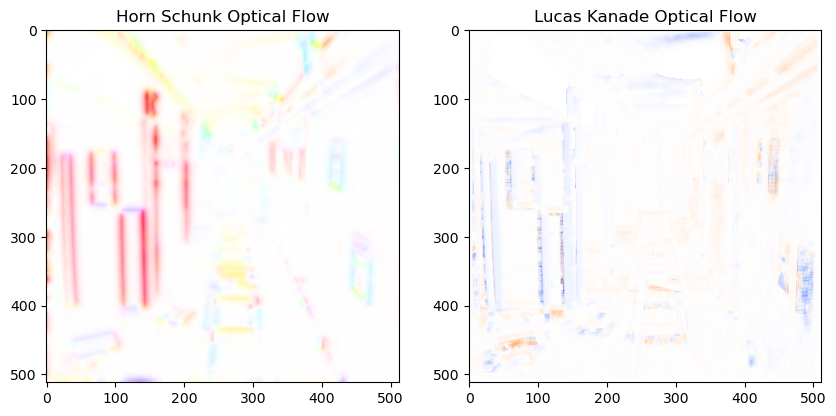

In [66]:
#call the function
flow_hs, _ = horn_schunk(first_frame, second_frame)
flow_lk, _ = lucas_kanade(first_frame, second_frame)

#plot both the flow images in a single figure, side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(list_to_flow_image(flow_hs))
ax[0].set_title("Horn Schunk Optical Flow")
ax[1].imshow(list_to_flow_image(flow_lk))
ax[1].set_title("Lucas Kanade Optical Flow")
plt.show()





In [67]:
#use function warp in pixel_wise_mapping.py to warp the an image using the flow
#warp has 2 necessary arguments, the image and the flow
#        x: [B, C, H, W]
        # flo: [B, 2, H, W] flow
        #thus we will be testing with a single image and flow, so batch size is 1 and we will add batch dimension to the image and flow
#write a wrapper function to warp an image using the flow
def warp_flow(image, flow):
        warped = remap_using_flow_fields(image, flow[0], flow[1])
        return warped

In [68]:
#defina a function to plot the first image , second image , the flow image and the warped image
def plot_warping(first_image, second_image, flow, warped_image):
        #first we will convert the flow to a flow image
        flow_image = list_to_flow_image(flow)
        #now we will plot the first image, second image, flow image and warped image in a single figure
        fig, ax = plt.subplots(1, 4, figsize=(20, 20))
        ax[0].imshow(first_image, cmap="gray")
        ax[0].set_title("First Image")
        ax[1].imshow(second_image, cmap="gray")
        ax[1].set_title("Second Image")
        ax[2].imshow(flow_image, cmap="gray")
        ax[2].set_title("Flow Image")
        ax[3].imshow(warped_image, cmap="gray")
        ax[3].set_title("Warped Image")
        plt.show()

In [69]:
#wrapper for the above function
def plot_warping_wrapper(first_image, second_image, method="hs"):
        #get optical flow as per the method
        if method == "hs":
                flow, _ = horn_schunk(first_image, second_image)
        elif method == "lk":
                flow, _ = lucas_kanade(first_image, second_image)
        #else error
        else:
                raise ValueError("method should be either hs or lk")
        #first we will convert the flow to a flow image
        flow_image = list_to_flow_image(flow)
        #now we will plot the first image, second image, flow image and warped image in a single figure
        warped_image = warp_flow(first_image, flow)
        plot_warping(first_image, second_image, flow, warped_image)

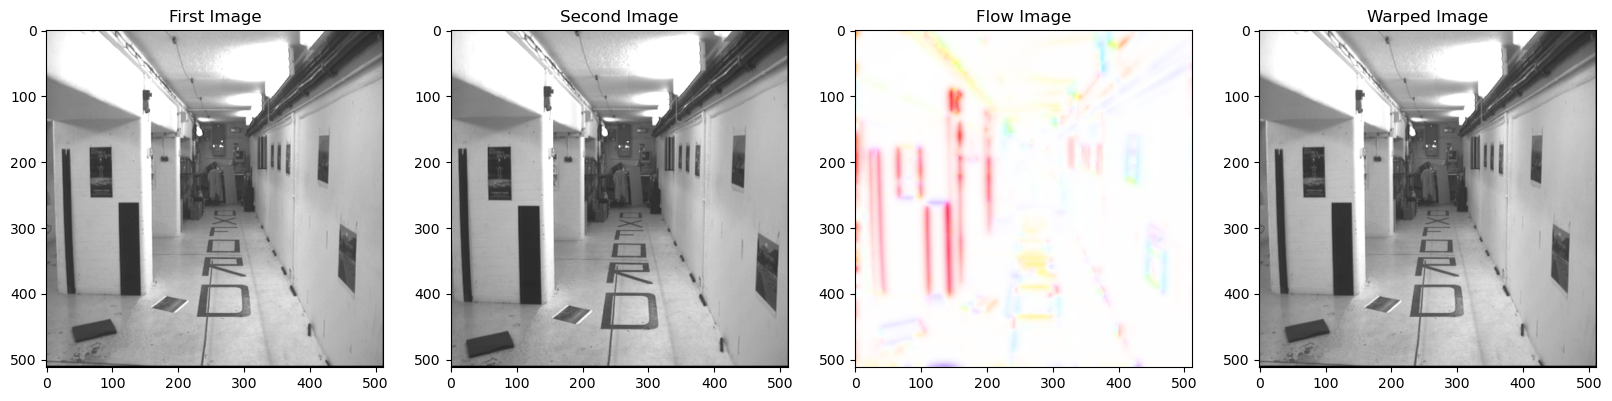

In [77]:
#call the function
plot_warping_wrapper(first_frame, second_frame, method="hs")

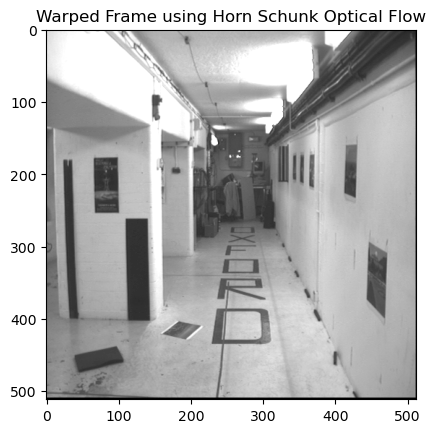

In [71]:
#test the warp_flow function on frame 1 and flow_hs
warped_frame_hs = warp_flow(first_frame, flow_hs)
#plot the warped frame
plt.imshow(warped_frame_hs, cmap="gray")
plt.title("Warped Frame using Horn Schunk Optical Flow")
plt.show()


(2, 512, 512)
(512, 512, 2)


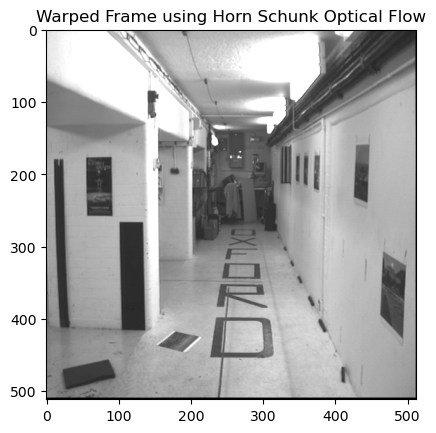

In [86]:
#use flowpy.backward_warp to warp the second frame using the flow
flow_hs_numpy = np.array(flow_hs)
#print the shape of flow_hs_numpy
print(flow_hs_numpy.shape)
#make the flow numpy array of shape (H, W, 2)
flow_hs_numpy = np.transpose(flow_hs_numpy, (1, 2, 0))
#print the shape of flow_hs_numpy
print(flow_hs_numpy.shape)
warped_frame_hs = flowpy.backward_warp(second_frame, flow_hs_numpy)

#plot the warped frame
plt.imshow(warped_frame_hs, cmap="gray")
plt.title("Warped Frame using Horn Schunk Optical Flow")
plt.show()


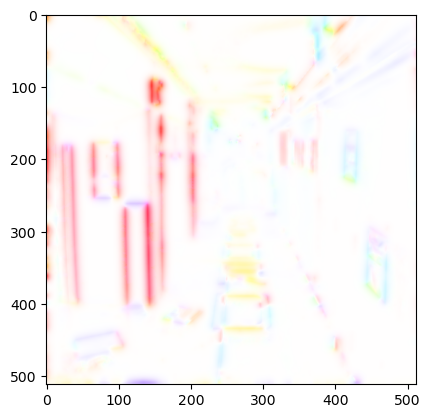

In [87]:
#print flow to rgb
fig, ax = plt.subplots()
ax.imshow(flowpy.flow_to_rgb(flow_hs_numpy))
plt.show()

## PSNR , SSIM